## Imports

In [1]:
# Importing necessary libraries for the analysis.
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.decomposition import PCA

## Configuration and Constants

In [2]:
# Defining the constants and configurations used throughout the notebook.
iterations = 101000
on_remote = False
SUBS_data_filename = Path('/nobackup/smhid20/users/sm_maran/dpr_data/simulations/QG_samples_SUBS_101000.npy') if on_remote else Path('C:/Users/svart/Desktop/MEX/data/QG_samples_SUBS_101000.npy')
k = 150
spinup = 1001
spacing = 10
p_train = 0.8

## Data Loading and Preprocessing

In [3]:
# Load the data and preprocess it for analysis.

# Load data from file
X_subs = np.load(SUBS_data_filename).astype('float32')

# Data preprocessing function
def generate_data(p_train, k, spinup, spacing, iterations, X_subs):
    """
    Generate training, validation, and test data from the provided dataset.
    
    Parameters:
    p_train (float): Percentage of data to be used for training.
    k (int): Time steps for prediction.
    spinup (int): Initial data to be ignored.
    spacing (int): Data spacing interval.
    iterations (int): Total number of iterations in the dataset.
    X_subs (numpy.array): The loaded dataset.

    Returns:
    tuple: Tuple containing training, validation, and test data.
    """
    N = iterations + 1
    n_train = int(np.round(p_train * (N - spinup)))
    n_val = int(np.round((1 - p_train)/2 * (N - spinup)))

    start, stop = spinup, spinup + n_train
    fit_x, fit_y = slice(start, stop - k), slice(start + k, stop)

    start, stop = stop, stop + n_val
    val_x, val_y = slice(start, stop - k), slice(start + k, stop)

    start, stop = stop, N
    prd_x, prd_y = slice(start, stop - k), slice(start + k, stop)

    # Data slicing
    X_train, Y_train = X_subs[fit_x], X_subs[fit_y]
    X_val, Y_val = X_subs[val_x], X_subs[val_y]
    X_test, Y_test = X_subs[prd_x], X_subs[prd_y]
        
    return X_train[::spacing], Y_train[::spacing], X_val[::spacing], Y_val[::spacing], X_test[::spacing], Y_test[::spacing]

# Generate the data
X_train, Y_train, X_val, Y_val, X_test, Y_test = generate_data(p_train, k, spinup, spacing, iterations, X_subs)


In [4]:
# Normalize function
def normalize_X(X, mean_data, std_data):
    """
    Normalize the data.

    Parameters:
    X (numpy.array): Data to be normalized.
    mean_data (float): Mean value for normalization.
    std_data (float): Standard deviation for normalization.

    Returns:
    numpy.array: Normalized data.
    """
    return (X - mean_data) / std_data

# Calculating mean and standard deviation for normalization
mean_data = X_train.mean()
std_data = X_train.std()

# Normalize data
X_train_normalized = normalize_X(X_train, mean_data, std_data)
X_val_normalized = normalize_X(X_val, mean_data, std_data)

IDEA: Normalize in dataloader instead?

## PCA Analysis

In [5]:
# Perform Principal Component Analysis (PCA) to understand the principal components of the data.

# Function for PCA analysis and reconstruction
def perform_pca(X_data, num_components):
    """
    Perform PCA analysis and reconstruct data using specified number of components.

    Parameters:
    X_data (numpy.array): Input data for PCA.
    num_components (int): Number of principal components to retain.

    Returns:
    tuple: Tuple containing transformed data and PCA object.
    """
    pca = PCA()
    X_transformed = pca.fit_transform(X_data)
    return X_transformed, pca

# Function for data reconstruction
def reconstruct_data(transformed_data, pca, l):
    """
    Reconstruct data using the first l components of PCA.

    Parameters:
    transformed_data (numpy.array): PCA transformed data.
    pca (PCA): PCA object.
    l (int): Number of components to use for reconstruction.

    Returns:
    numpy.array: Reconstructed data.
    """
    return np.dot(transformed_data[:, :l], pca.components_[:l, :]) + pca.mean_

# Function to calculate reconstruction error
def reconstruction_error(original_data, reconstructed_data):
    """
    Calculate the mean squared reconstruction error.

    Parameters:
    original_data (numpy.array): Original data.
    reconstructed_data (numpy.array): Reconstructed data.

    Returns:
    float: Mean squared error.
    """
    return np.mean(np.square(original_data - reconstructed_data))

def get_encoded(x, l):
    return x[:l]


In [6]:
# Perform PCA
latent_PCA, pca = perform_pca(X_train_normalized, num_components=4225)

In [7]:
# Select a specific l for demonstration
l = 100
X_train_reconstruced_PCA = reconstruct_data(latent_PCA, pca, l)
error = reconstruction_error(X_train_normalized, X_train_reconstruced_PCA)

print(f"Reconstruction Error for l={l}: {error}")

Reconstruction Error for l=100: 0.020044289529323578


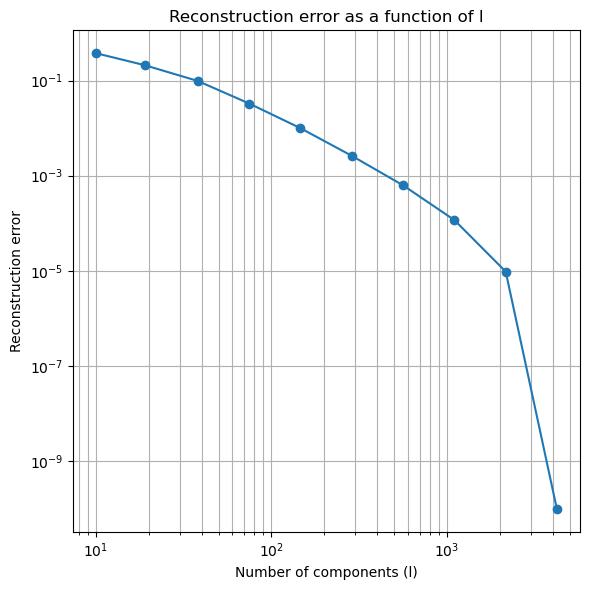

In [31]:
# Analyze reconstruction error for different number of components
l_values = [int(l) for l in np.logspace(1, np.log10(4225), 10)]
errors = [reconstruction_error(X_train_normalized, reconstruct_data(latent_PCA, pca, l)) for l in l_values]

# Plotting the reconstruction errors
plt.figure(figsize=(6,6))
plt.loglog(l_values, errors, marker='o')
plt.grid(True, 'both')
plt.xlabel('Number of components (l)')
plt.ylabel('Reconstruction error')
plt.title('Reconstruction error as a function of l')
plt.tight_layout()
plt.show()

0.9765238


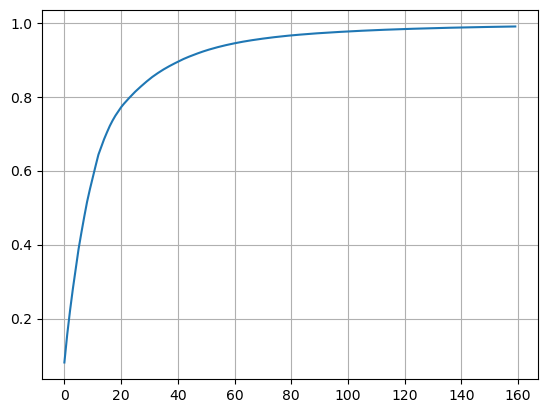

In [56]:
print(pca.explained_variance_ratio_.cumsum()[100])
plt.plot(pca.explained_variance_ratio_.cumsum()[:160])
plt.grid(which='both')

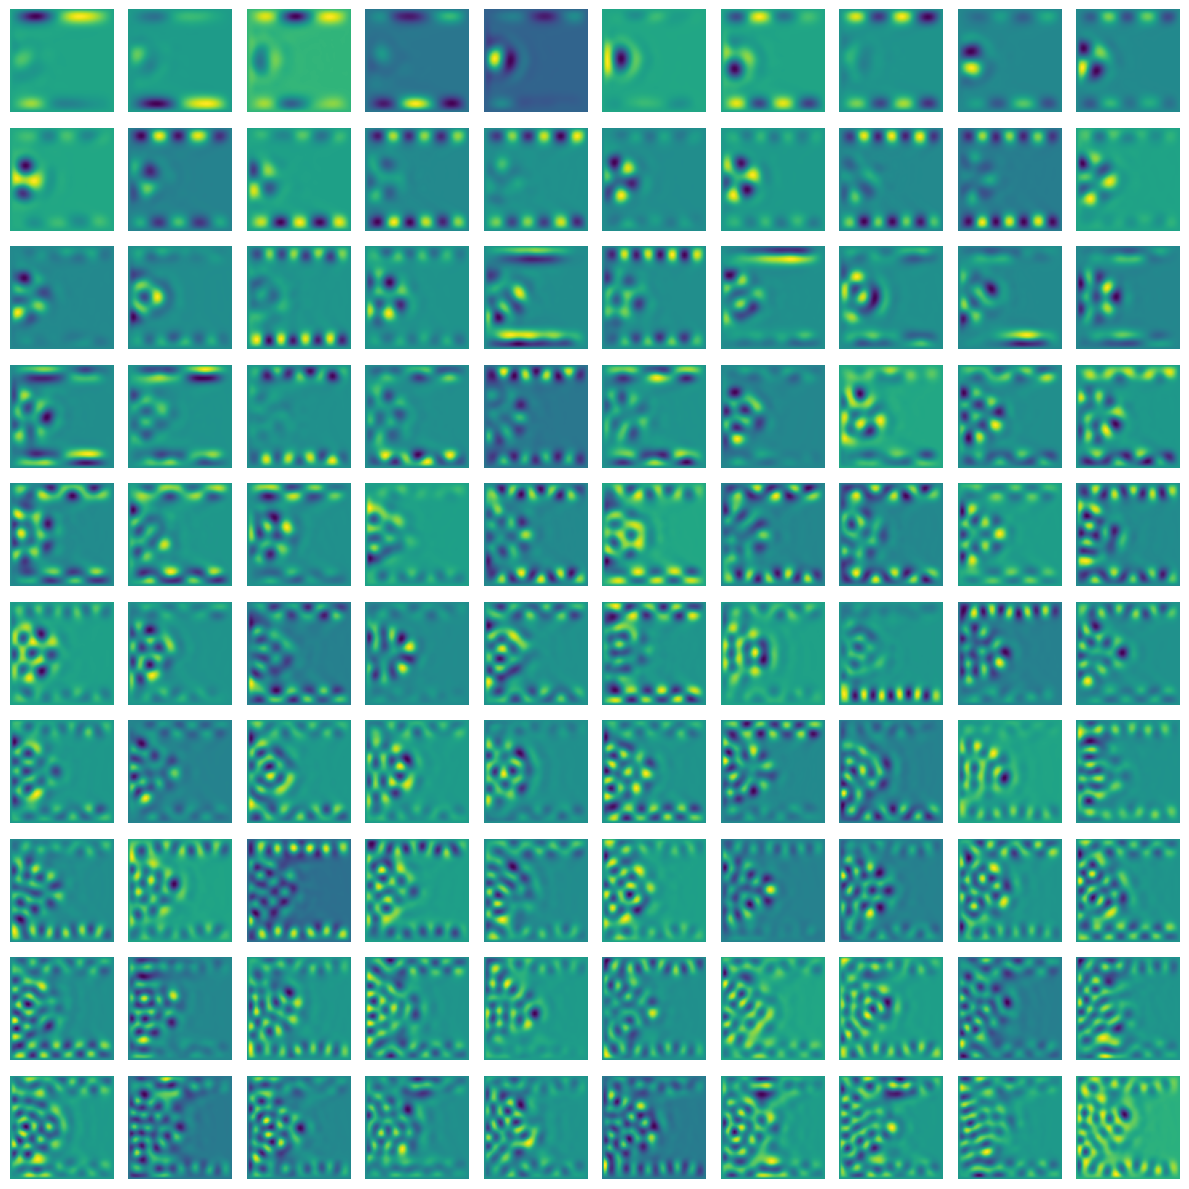

In [108]:
K = 100  # Number of components to 
bias_K = 0 # Bias to start from

fig, axs = plt.subplots(K//10, 10, figsize=(12, 12))
axs = axs.flatten()


for i in range(K):
    axs[i].imshow(pca.components_[i+bias_K, :].reshape(65, 65))
    axs[i].axis('off')

plt.tight_layout()
plt.show()


## Autoencoder Implementation

In [8]:
# Implementing Autoencoders for feature extraction and data reconstruction.

# Function to convert data to PyTorch DataLoader
def create_dataloader(X_data, batch_size, shuffle=True):
    """
    Convert data to PyTorch DataLoader.

    Parameters:
    X_data (numpy.array): Data to be converted.
    batch_size (int): Batch size for the DataLoader.
    shuffle (bool): Whether to shuffle the data.

    Returns:
    DataLoader: PyTorch DataLoader object.
    """
    X_tensor = torch.tensor(X_data, dtype=torch.float32).to(device)
    dataset = TensorDataset(X_tensor[:-1], X_tensor[1:])
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create DataLoaders for training and validation data
batch_size = 64
train_loader = create_dataloader(X_train_normalized, batch_size)
val_loader = create_dataloader(X_val_normalized, batch_size, shuffle=False)

Using device: cuda:0


### Architectures

In [9]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size[0]),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size[0], input_size),
        )
        self.apply(self.init_weights)

    @staticmethod  
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        x = self.encoder(x)
        activations = x  # Store the activations from the encoder
        x = self.decoder(x)
        return x, activations

In [10]:
# Old
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.image_size = 65
        
        self.encoder = nn.Sequential(
            nn.Unflatten(1,(1,self.image_size, self.image_size)),
            # 1x65x65
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # 32x65x65
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # 32x65x65
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # 32x65x65
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # 32x65x65
            nn.Flatten(start_dim=1),
            nn.Linear(in_features=32*65*65, out_features=100),
            )
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features=100, out_features=32*65*65),
            nn.ReLU(),
            nn.Unflatten(1,(32, self.image_size, self.image_size)),
            # 32x65x65
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # 32x65x65
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # 32x65x65
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # 32x65x65
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1),
            nn.Flatten(start_dim=1),
            )
        
        self.apply(self.init_weights)

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            torch.nn.init.constant_(m.weight, 1)
            torch.nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.encoder(x)
        activations = x  # Store the activations from the encoder
        x = self.decoder(x)
        return x, activations

In [105]:
# New
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.image_size = 65
        
        self.encoder = nn.Sequential(
            nn.Unflatten(1,(1,self.image_size, self.image_size)),
            # 1x65x65
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=4, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # 16x64x64
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # 16x64x64
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 16x32x32
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # 32x32x32
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 32x16x16
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # 64x16x16
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU(True),
            # 1x16x16
            nn.Flatten(start_dim=1),
            nn.Linear(in_features=256,out_features=100),
            )
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features=100,out_features=256),
            nn.Unflatten(1,(1, 16, 16)),
            # 1x16x16
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # 64x16x16
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2),
            # 64x32x32
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # 32x32x32
            nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=2, stride=2),
            # 32x64x64
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            #nn.BatchNorm2d(16),
            nn.ReLU(True),
            # 16x64x64
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            #nn.BatchNorm2d(16),
            nn.ReLU(True),
            # 16x64x64
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=4, padding=1),
            # 1x65x65
            nn.Flatten(start_dim=1),
            )
        
        self.apply(self.init_weights)

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            torch.nn.init.constant_(m.weight, 1)
            torch.nn.init.constant_(m.bias, 0)


    def forward(self, x):
        x = self.encoder(x)
        activations = x  # Store the activations from the encoder
        x = self.decoder(x)
        return x, activations

### Define network

In [86]:
linear_model = Autoencoder(input_size=4225, hidden_size=(100,))  # Example sizes
linear_model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(linear_model.parameters(), lr=1e-3)

loss_values = []
val_loss_values = []

model = linear_model

In [106]:
conv_model = ConvAutoencoder()
conv_model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(conv_model.parameters(), lr=1e-3)#, weight_decay=0.0001)

loss_values = []
val_loss_values = []

model = conv_model

### No reg

In [107]:
num_epochs = 500

best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_train_loss = 0
    
    for data in train_loader:
        img, _ = data

        optimizer.zero_grad()

        output, activations = model(img)

        # Recondstruction loss
        recon_loss = criterion(output, img)
        loss = recon_loss 

        total_train_loss += loss.item()


        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            img, _ = data

            output, _ = model(img)
            loss = criterion(output, img)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    # Learning rate scheduling (if applicable)
    # scheduler.step()

    loss_values.append([avg_train_loss])
    val_loss_values.append(avg_val_loss)  # Assuming val_loss_values list exists

    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Plotting
plt.figure(figsize=(10, 6))
loss_plot = np.array(loss_values)
plt.semilogy(loss_plot, label='Training Loss', color='blue')

plt.semilogy(val_loss_values, label='Validation Loss', color='red')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

Epoch [1/500], Average Loss: 0.4301, Validation Loss: 0.2257
Epoch [2/500], Average Loss: 0.1478, Validation Loss: 0.1371
Epoch [3/500], Average Loss: 0.1016, Validation Loss: 0.1103
Epoch [4/500], Average Loss: 0.0842, Validation Loss: 0.0975
Epoch [5/500], Average Loss: 0.0733, Validation Loss: 0.0848
Epoch [6/500], Average Loss: 0.0665, Validation Loss: 0.0775
Epoch [7/500], Average Loss: 0.0607, Validation Loss: 0.0724
Epoch [8/500], Average Loss: 0.0561, Validation Loss: 0.0697
Epoch [9/500], Average Loss: 0.0537, Validation Loss: 0.0650
Epoch [10/500], Average Loss: 0.0501, Validation Loss: 0.0610
Epoch [11/500], Average Loss: 0.0472, Validation Loss: 0.0563
Epoch [12/500], Average Loss: 0.0457, Validation Loss: 0.0582
Epoch [13/500], Average Loss: 0.0435, Validation Loss: 0.0533
Epoch [14/500], Average Loss: 0.0417, Validation Loss: 0.0492
Epoch [15/500], Average Loss: 0.0410, Validation Loss: 0.0502


KeyboardInterrupt: 

### L1

In [12]:
num_epochs = 50

lambda_l1 = 0.002
lambda_l2 = 0.0002
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_train_loss = 0
    total_recon_loss = 0
    total_l1_loss = 0
    total_l2_loss = 0
    
    for data in train_loader:
        img, _ = data

        optimizer.zero_grad()

        output, activations = model(img)

        # Recondstruction loss
        recon_loss = criterion(output, img)

        # L1 regularization
        l1_loss = lambda_l1 * torch.mean(torch.norm(activations, 1, dim=1))

        # Calculate L2 loss (sum of absolute values of weights)
        l2_loss = 0
        for param in model.parameters():
            l2_loss += torch.norm(param, 2)

        l2_loss *= lambda_l2

        loss = recon_loss + l1_loss + l2_loss

        total_train_loss += loss.item()

        total_recon_loss += recon_loss.item()
        total_l1_loss += l1_loss.item()
        total_l2_loss += l2_loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_recon_loss = total_recon_loss / len(train_loader)
    avg_l1_loss = total_l1_loss / len(train_loader)
    avg_l2_loss = total_l2_loss / len(train_loader)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            img, _ = data

            output, _ = model(img)
            loss = criterion(output, img)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    # Learning rate scheduling (if applicable)
    # scheduler.step()

    loss_values.append([avg_train_loss, avg_recon_loss, avg_l1_loss, avg_l2_loss])
    val_loss_values.append(avg_val_loss)  # Assuming val_loss_values list exists

    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_train_loss:.4f}, Reconstruction: {avg_recon_loss:.4f}, L1: {avg_l1_loss:.4f}, L2: {avg_l2_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Plotting
plt.figure(figsize=(10, 6))
loss_plot = np.array(loss_values)
plt.loglog(loss_plot[:,0], label='Training Loss', color='blue')
plt.loglog(loss_plot[:,1], label='Reconstruction Loss', color='orange')
plt.loglog(loss_plot[:,2], label='L1 Loss', color='green')
plt.loglog(loss_plot[:,3], label='L2 Loss', color='purple')

plt.loglog(val_loss_values, label='Validation Loss', color='red')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

Epoch [1/50], Average Loss: 1.5558, Reconstruction: 1.3585, L1: 0.1159, L2: 0.0815, Validation Loss: 0.5362
Epoch [2/50], Average Loss: 0.5447, Reconstruction: 0.3351, L1: 0.1268, L2: 0.0827, Validation Loss: 0.2578
Epoch [3/50], Average Loss: 0.3938, Reconstruction: 0.1736, L1: 0.1387, L2: 0.0815, Validation Loss: 0.1533
Epoch [4/50], Average Loss: 0.3382, Reconstruction: 0.1197, L1: 0.1393, L2: 0.0792, Validation Loss: 0.1414
Epoch [5/50], Average Loss: 0.2778, Reconstruction: 0.0905, L1: 0.1110, L2: 0.0763, Validation Loss: 0.0958
Epoch [6/50], Average Loss: 0.1817, Reconstruction: 0.0561, L1: 0.0526, L2: 0.0730, Validation Loss: 0.0591
Epoch [7/50], Average Loss: 0.1188, Reconstruction: 0.0272, L1: 0.0218, L2: 0.0698, Validation Loss: 0.0322
Epoch [8/50], Average Loss: 0.0966, Reconstruction: 0.0188, L1: 0.0134, L2: 0.0644, Validation Loss: 0.0263
Epoch [9/50], Average Loss: 0.0817, Reconstruction: 0.0157, L1: 0.0103, L2: 0.0556, Validation Loss: 0.0232
Epoch [10/50], Average Loss:

KeyboardInterrupt: 

### Cont. Latent space

In [273]:
num_epochs = 50
lambda_l1 = 0.001
lambda_cont = 0.01
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_train_loss = 0
    total_recon_loss = 0
    total_l1_loss = 0
    total_cont_loss = 0
    
    for data in train_loader:
        img, _ = data

        optimizer.zero_grad()

        output, activations = model(img)

        recon_loss = criterion(output, img)

        cont_loss = lambda_cont * criterion(activations[:-1], activations[1:])

        l1_loss = lambda_l1 * torch.mean(torch.norm(activations, 1, dim=1))

        loss = recon_loss + l1_loss + cont_loss

        total_train_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_l1_loss += l1_loss.item()
        total_cont_loss += cont_loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_recon_loss = total_recon_loss / len(train_loader)
    avg_l1_loss = total_l1_loss / len(train_loader)
    avg_cont_loss = total_cont_loss / len(train_loader)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            img, _ = data

            output, _ = model(img)
            loss = criterion(output, img)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    # Learning rate scheduling (if applicable)
    # scheduler.step()

    loss_values.append([avg_train_loss, avg_recon_loss, avg_l1_loss, avg_cont_loss])
    val_loss_values.append(avg_val_loss)  # Assuming val_loss_values list exists

    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_train_loss:.4f}, Reconstruction: {avg_recon_loss:.4f}, L1: {avg_l1_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Cont: {avg_cont_loss:.4f}')
# Plotting
plt.figure(figsize=(10, 6))
loss_plot = np.array(loss_values)
plt.loglog(loss_plot[:,0], label='Training Loss', color='blue')
plt.loglog(loss_plot[:,1], label='Reconstruction Loss', color='orange')
plt.loglog(loss_plot[:,2], label='Regularization Loss', color='green')
plt.loglog(loss_plot[:,3], label='Continuity Loss', color='purple')

plt.loglog(val_loss_values, label='Validation Loss', color='red')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

Epoch [1/50], Average Loss: 0.0181, Reconstruction: 0.0133, L1: 0.0047, Validation Loss: 0.0225, Cont: 0.0001
Epoch [2/50], Average Loss: 0.0176, Reconstruction: 0.0130, L1: 0.0045, Validation Loss: 0.0232, Cont: 0.0001
Epoch [3/50], Average Loss: 0.0173, Reconstruction: 0.0129, L1: 0.0044, Validation Loss: 0.0226, Cont: 0.0001
Epoch [4/50], Average Loss: 0.0167, Reconstruction: 0.0124, L1: 0.0042, Validation Loss: 0.0220, Cont: 0.0001
Epoch [5/50], Average Loss: 0.0164, Reconstruction: 0.0123, L1: 0.0041, Validation Loss: 0.0236, Cont: 0.0001
Epoch [6/50], Average Loss: 0.0160, Reconstruction: 0.0120, L1: 0.0040, Validation Loss: 0.0223, Cont: 0.0001
Epoch [7/50], Average Loss: 0.0157, Reconstruction: 0.0118, L1: 0.0039, Validation Loss: 0.0234, Cont: 0.0001
Epoch [8/50], Average Loss: 0.0159, Reconstruction: 0.0121, L1: 0.0038, Validation Loss: 0.0232, Cont: 0.0001
Epoch [9/50], Average Loss: 0.0150, Reconstruction: 0.0113, L1: 0.0037, Validation Loss: 0.0222, Cont: 0.0001
Epoch [10/

KeyboardInterrupt: 

### Regularized Loss CAE

In [168]:
best_val_loss = float('inf')

alpha = 1

num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_train_loss = 0
    total_train_loss_reconstruction = 0
    total_train_loss_temporal = 0
    
    for current_state, next_state in train_loader:
        current_reconstruction, current_latent = model(current_state)
        next_reconstruction, next_latent = model(next_state)
        
        loss_temporal = criterion(current_latent, next_latent)
        
        loss_reconstruction = criterion(current_reconstruction, current_state) + \
                              criterion(next_reconstruction, next_state)
        
        loss = loss_reconstruction + alpha * loss_temporal
        
        total_train_loss += loss.item()
        total_train_loss_reconstruction += loss_reconstruction.item()
        total_train_loss_temporal += loss_temporal.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    total_train_loss_reconstruction /= 2 * len(train_loader)
    total_train_loss_temporal /= len(train_loader)
    total_train_loss /= len(train_loader)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            img, _ = data

            output,_ = model(img)
            loss = criterion(output, img)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    # Learning rate scheduling (if applicable)
    # scheduler.step()

    loss_values.append([total_train_loss, total_train_loss_reconstruction, total_train_loss_temporal])
    val_loss_values.append(avg_val_loss)  # Assuming val_loss_values list exists

    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {total_train_loss:.4f}, Reconstruction: {total_train_loss_reconstruction:.4f}, Temporal: {total_train_loss_temporal:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Plotting
plt.figure(figsize=(10, 6))
loss_plot = np.array(loss_values)
plt.loglog(loss_plot[:,0], label='Training Loss', color='blue')
plt.loglog(loss_plot[:,1], label='Reconstruction Loss', color='orange')
plt.loglog(loss_plot[:,2], label='Temporal Loss', color='green')

plt.loglog(val_loss_values, label='Validation Loss', color='red')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

Epoch [1/10], Average Loss: 8.3379, Reconstruction: 4.0765, Temporal: 0.1850, Validation Loss: 1.1321


KeyboardInterrupt: 

## Evaluation of PCA and Autoencoder Models

In [61]:
# Evaluating the performance of the PCA and Autoencoder models on the validation set.

# Function for model evaluation
def evaluate_model(model, X_data, criterion, pca, l):
    """
    Evaluate the model performance.

    Parameters:
    model (nn.Module): PyTorch model to evaluate.
    X_data (numpy.array): Data to evaluate the model on.
    criterion (function): Loss function.
    pca (PCA): PCA object.
    l (int): Number of PCA components.

    Returns:
    tuple: Tuple containing reconstruction errors for PCA and Autoencoder.
    """
    with torch.no_grad():
        X_transformed = pca.transform(X_data)
        X_PCA_reconstructed = reconstruct_data(X_transformed, pca, l)
        error_pca = reconstruction_error(X_data, X_PCA_reconstructed)

        X_tensor = torch.tensor(X_data, dtype=torch.float32).to(device)
        X_AE_reconstructed= model(X_tensor)[0].cpu().numpy()
        error_ae = reconstruction_error(X_data, X_AE_reconstructed)

        return error_pca, error_ae, X_PCA_reconstructed, X_AE_reconstructed

# Evaluate the models
error_pca, error_ae, X_PCA_test, X_AE_test = evaluate_model(model, X_val_normalized, nn.MSELoss(), pca, l=100)
print(f"PCA Reconstruction Error: {error_pca}, Autoencoder Reconstruction Error: {error_ae}")

PCA Reconstruction Error: 0.02382008358836174, Autoencoder Reconstruction Error: 0.01844726875424385


## Visualization

In [16]:
X_val_tensor = torch.tensor(X_val_normalized, dtype=torch.float32).to(device)  # Convert to tensor
X_train_tensor = torch.tensor(X_train_normalized, dtype=torch.float32).to(device)
cmap = 'viridis'
choose_random = True

In [62]:
def get_images(random_index, X=X_val_tensor):
    model.eval()

    l = 100
    X_transformed = pca.transform(X.cpu().detach().numpy())
    X_PCA = reconstruct_data(X_transformed, pca, l)
    
    image_shape = (65, 65)  # Replace with the actual shape of your images
    latent_shape = (10, 10)  # Replace with the actual shape of your images

    img_train = X.cpu().detach().numpy()[random_index].reshape(image_shape)
    img_train_next = X.cpu().detach().numpy()[random_index+1].reshape(image_shape)

    img_pca = X_PCA[random_index].reshape(image_shape)
    img_pca_next = X_PCA[random_index+1].reshape(image_shape)

    img_ae = model(X[random_index].unsqueeze(0))[0].cpu().detach().numpy().reshape(image_shape)
    img_ae_next = model(X[random_index+1].unsqueeze(0))[0].cpu().detach().numpy().reshape(image_shape)

    img_pca_enc = get_encoded(X_PCA[random_index], l)
    img_pca_enc_next = get_encoded(X_PCA[random_index+1],l)

    img_ae_enc = model.encoder(X[random_index].unsqueeze(0)).cpu().detach().numpy().flatten()
    img_ae_enc_next = model.encoder(X_val_tensor[random_index+1].unsqueeze(0)).cpu().detach().numpy().flatten()

    return img_train, img_train_next, img_pca, img_pca_next, img_ae, img_ae_next, img_pca_enc, img_pca_enc_next, img_ae_enc, img_ae_enc_next

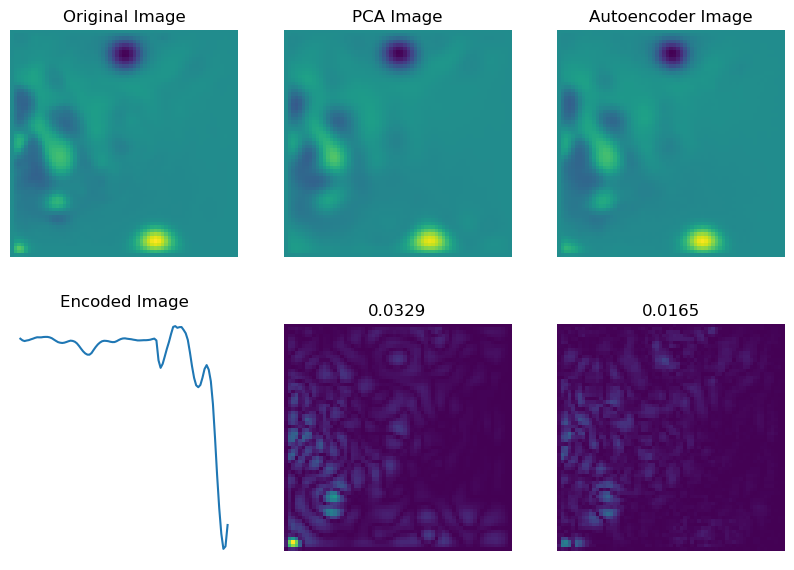

In [101]:
if choose_random:
    random_index = np.random.randint(len(X_val))
img_train, img_train_next, img_pca, img_pca_next, img_ae, img_ae_next, img_pca_enc, img_pca_enc_next, img_ae_enc, img_ae_enc_next = get_images(random_index=random_index, X=X_train_tensor)

vmin = min(img_pca.min(), img_train.min(), img_ae.min())
vmax = max(img_pca.max(), img_train.max(), img_ae.max())

#cmap = 'Greys'

fig, axes = plt.subplots(2, 3, figsize=(10, 7))
axes[0,0].imshow(img_train, cmap=cmap, vmin=vmin, vmax=vmax)
axes[0,0].set_title('Original Image')
axes[0,0].axis('off')

axes[0,1].imshow(img_pca, cmap=cmap, vmin=vmin, vmax=vmax)
axes[0,1].set_title(f'PCA Image')
axes[0,1].axis('off')

axes[0,2].imshow(img_ae, cmap=cmap, vmin=vmin, vmax=vmax)
axes[0,2].set_title(f'Autoencoder Image')
axes[0,2].axis('off')

axes[1,0].plot(img_pca_enc.flatten())
axes[1,0].set_title('Encoded Image')
axes[1,0].axis('off')

#vmin_diff = min((img_pca-img_train).min(), (img_ae-img_train).min())
vmax_diff = max((np.abs(img_pca-img_train)).max(), (np.abs(img_ae-img_train)).max())

axes[1,1].imshow(np.abs(img_pca- img_train), cmap=cmap, vmin=0, vmax=vmax_diff)
er_PCA = np.round(reconstruction_error(img_train, img_pca),4)
axes[1,1].set_title(f'{str(er_PCA)}')
axes[1,1].axis('off')

axes[1,2].imshow(np.abs(img_ae-img_train), cmap=cmap, vmin=0, vmax=vmax_diff)
er_AE = np.round(reconstruction_error(img_train, img_ae), 4)
axes[1,2].set_title(f'{str(er_AE)}')
axes[1,2].axis('off')

plt.show()

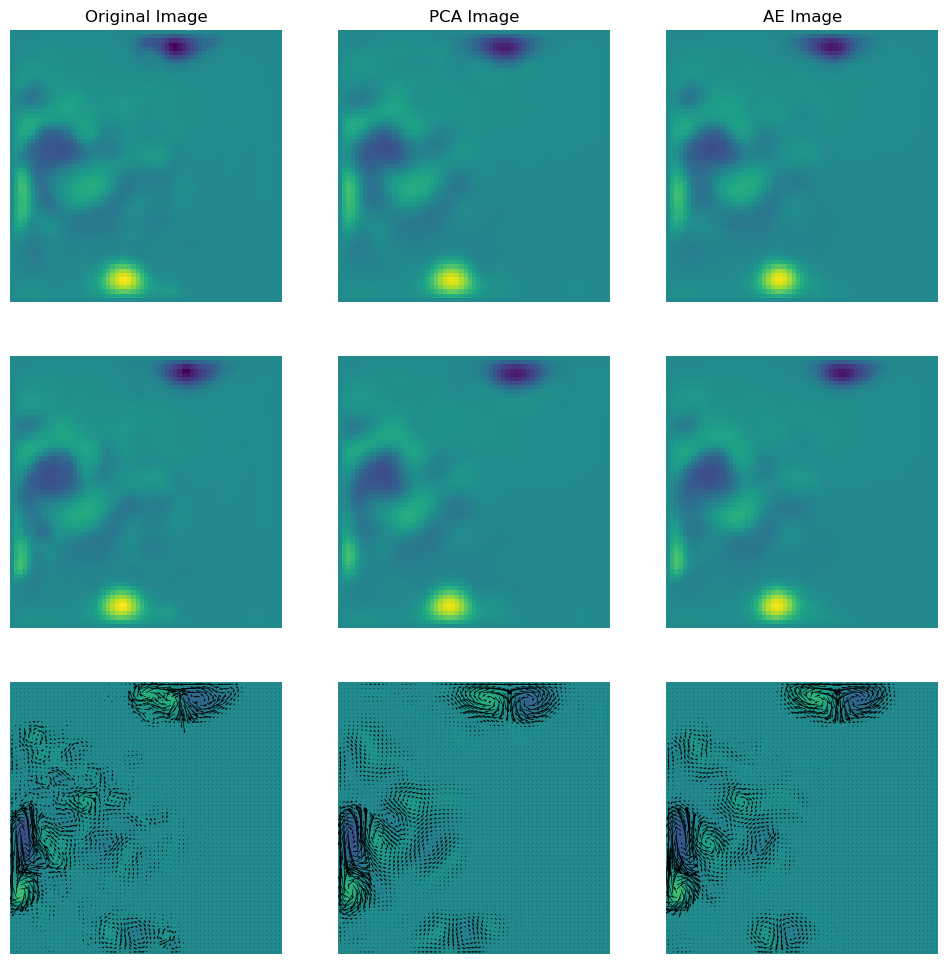

In [19]:
if choose_random:
    random_index = np.random.randint(len(X_val))
img_train, img_train_next, img_pca, img_pca_next, img_ae, img_ae_next, img_pca_enc, img_pca_enc_next, img_ae_enc, img_ae_enc_next = get_images(random_index=random_index)


vmin = min(img_pca.min(), img_train.min(), img_train_next.min(), img_pca_next.min())
vmax = max(img_pca.max(), img_train.max(), img_train_next.max(), img_pca_next.max())

fig, axes = plt.subplots(3,3, figsize=(12, 12))

# Train
axes[0,0].imshow(img_train, cmap=cmap, vmin=vmin, vmax=vmax)
axes[0,0].set_title('Original Image')
axes[0,0].axis('off')

axes[1,0].imshow(img_train_next, cmap=cmap, vmin=vmin, vmax=vmax)
axes[1,0].axis('off')

gradient_x, gradient_y = np.gradient(img_train_next - img_train)
X, Y = np.meshgrid(np.arange(gradient_x.shape[1]), np.arange(gradient_y.shape[0]))
axes[2,0].imshow(img_train_next - img_train, cmap=cmap, vmin=vmin, vmax=vmax)
axes[2,0].quiver(X, Y, gradient_x, gradient_y)
axes[2,0].axis('off')


# PCA
axes[0,1].imshow(img_pca, cmap=cmap, vmin=vmin, vmax=vmax)
axes[0,1].set_title(f'PCA Image')
axes[0,1].axis('off')

axes[1,1].imshow(img_pca_next, cmap=cmap, vmin=vmin, vmax=vmax)
axes[1,1].axis('off')

# Compute the difference
difference = img_pca_next - img_pca
gradient_x, gradient_y = np.gradient(difference)
axes[2,1].imshow(img_pca_next - img_pca, cmap=cmap, vmin=vmin, vmax=vmax)
axes[2,1].quiver(X, Y, gradient_x, gradient_y)
axes[2,1].axis('off')

# AE
axes[0,2].imshow(img_ae, cmap=cmap, vmin=vmin, vmax=vmax)
axes[0,2].set_title(f'AE Image')
axes[0,2].axis('off')

axes[1,2].imshow(img_ae_next, cmap=cmap, vmin=vmin, vmax=vmax)
axes[1,2].axis('off')

# Compute the difference
difference = img_ae_next - img_ae
gradient_x, gradient_y = np.gradient(difference)
axes[2,2].imshow(img_ae_next - img_ae, cmap=cmap, vmin=vmin, vmax=vmax)
axes[2,2].quiver(X, Y, gradient_x, gradient_y)
axes[2,2].axis('off')


plt.show()

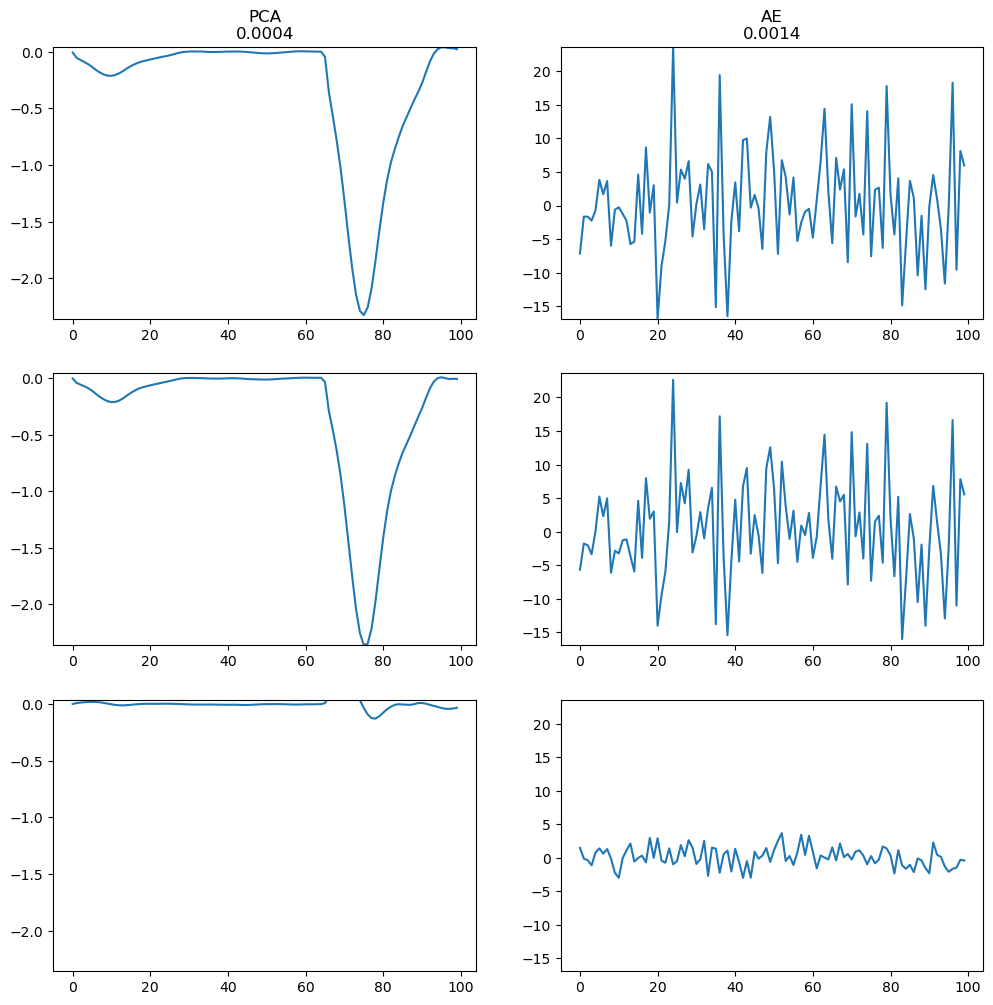

In [37]:
if choose_random:
    random_index = np.random.randint(len(X_val))
img_train, img_train_next, img_pca, img_pca_next, img_ae, img_ae_next, img_pca_enc, img_pca_enc_next, img_ae_enc, img_ae_enc_next = get_images(random_index=random_index)


vmin_pca = min(img_pca_enc.min(), img_pca_enc_next.min())
vmax_pca = max(img_pca_enc.max(), img_pca_enc_next.max())

err_pca = str(np.round(np.mean(((img_pca_enc_next - img_pca_enc)/(vmax_pca - vmin_pca))**2),4))

vmin_ae = min(img_ae_enc.min(), img_ae_enc_next.min())
vmax_ae = max(img_ae_enc.max(), img_ae_enc_next.max())

err_ae = str(np.round(np.mean(((img_ae_enc_next - img_ae_enc)/(vmax_ae - vmin_ae))**2),4))

fig, axes = plt.subplots(3,2, figsize=(12, 12))

axes[0,0].plot(img_pca_enc)
axes[0,0].set_title(f'PCA\n{err_pca}')
axes[0,0].set_ylim([vmin_pca, vmax_pca])

axes[1,0].plot(img_pca_enc_next)
axes[1,0].set_ylim([vmin_pca, vmax_pca])

axes[2,0].plot(img_pca_enc_next - img_pca_enc)
axes[2,0].set_ylim([vmin_pca, vmax_pca])


axes[0,1].plot(img_ae_enc)
axes[0,1].set_title(f'AE\n{err_ae}')
axes[0,1].set_ylim([vmin_ae, vmax_ae])
axes[1,1].plot(img_ae_enc_next)
axes[1,1].set_ylim([vmin_ae, vmax_ae])
axes[2,1].plot(img_ae_enc_next - img_ae_enc)
axes[2,1].set_ylim([vmin_ae, vmax_ae])


plt.show()


## Latent space visuals

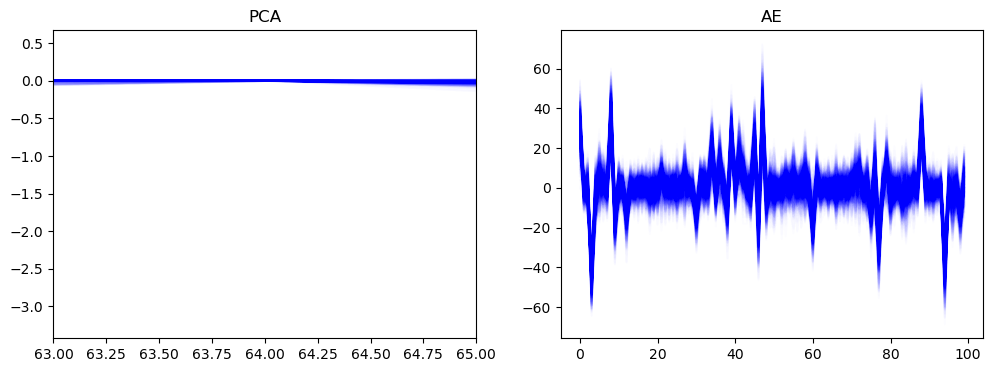

In [98]:
model.eval()

l = 100

cmap = 'viridis'
random_index = np.random.randint(len(X_val))

fig, axes = plt.subplots(1,2, figsize=(12, 4))

axes[0].set_title(f'PCA')
axes[1].set_title(f'AE')

for i in range(len(X_val)):
    random_index = i
    img_pca_enc = get_encoded(X_PCA_test[random_index], l)
    #img_pca_enc_next = get_encoded(X_PCA_test[random_index+1],l)

    img_ae_enc = model.encoder(X_val_tensor[random_index].unsqueeze(0)).cpu().detach().numpy().flatten()
    #img_ae_enc_next = model.encoder(X_val_tensor[random_index+1].unsqueeze(0)).cpu().detach().numpy().flatten()

    axes[0].plot(img_pca_enc, alpha=0.01, color='blue')

    axes[1].plot(img_ae_enc, alpha=0.01, color='blue')

axes[0].set_xlim([63,65])
plt.show()
random_index = 0


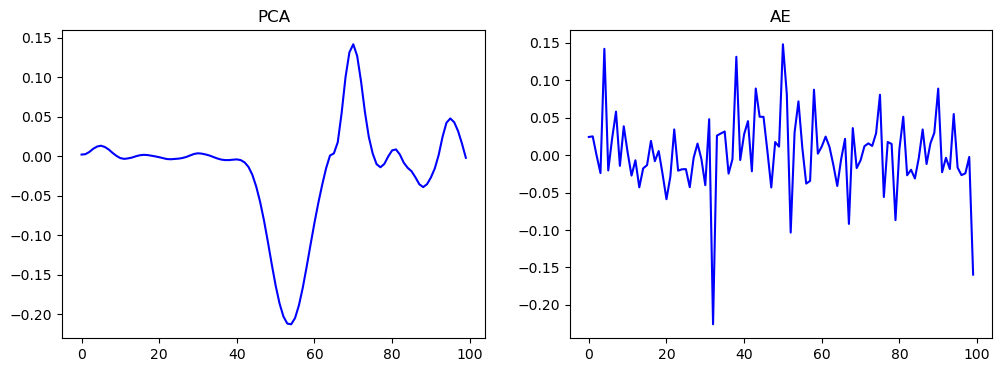

In [50]:
model.eval()

l = 100

cmap = 'viridis'

fig, axes = plt.subplots(1,2, figsize=(12, 4))

axes[0].set_title(f'PCA')
axes[1].set_title(f'AE')

#random_index = 0

random_index += 1
img_pca_enc = get_encoded(X_PCA_test[random_index], l)

img_ae_enc = model.encoder(X_val_tensor[random_index].unsqueeze(0)).cpu().detach().numpy().flatten()

axes[0].plot(img_pca_enc, color='blue')
axes[1].plot(img_ae_enc, color='blue')

plt.show()


### CNN Visualizer

TypeError: Invalid shape (22, 42, 32) for image data

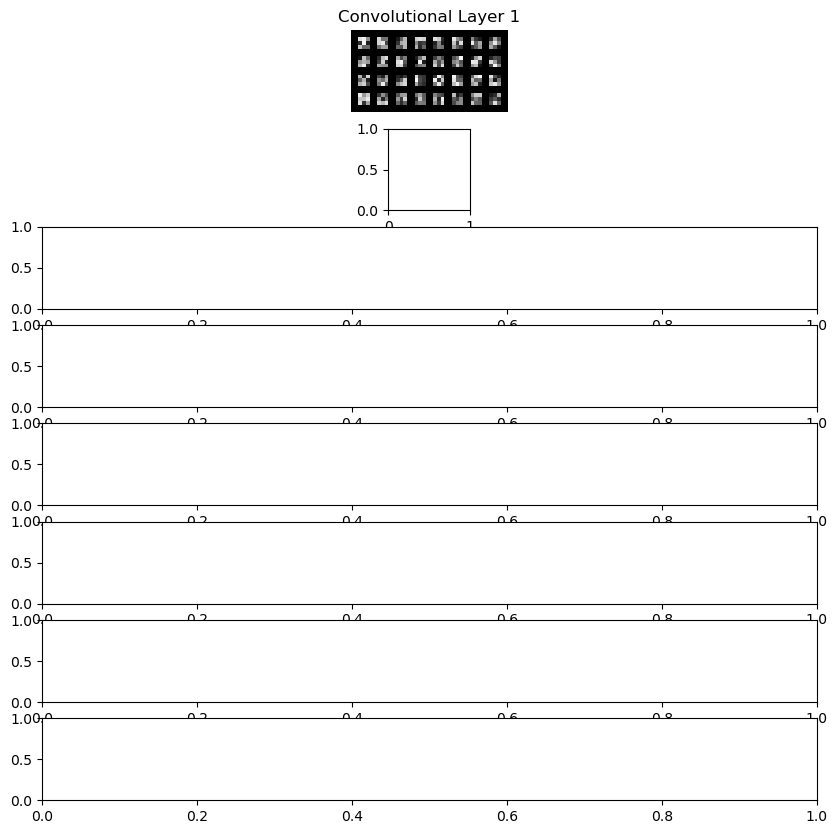

In [40]:
import torch
import torchvision
import matplotlib.pyplot as plt


# Get the convolutional layers
conv_layers = []
for module in model.modules():
    if isinstance(module, torch.nn.Conv2d):
        conv_layers.append(module)

# Visualize the filters in each convolutional layer
fig, axes = plt.subplots(len(conv_layers), 1, figsize=(10, 10))
for i, conv_layer in enumerate(conv_layers):
    filters = conv_layer.weight.detach().clone()
    filters = filters - filters.min()
    filters = filters / filters.max()
    filters = torchvision.utils.make_grid(filters, nrow=8)
    axes[i].imshow(filters.cpu().permute(1, 2, 0))
    axes[i].axis('off')
    axes[i].set_title(f'Convolutional Layer {i+1}')

plt.tight_layout()
plt.show()


In [37]:
for ix in conv_layers:
    print(ix.weight.shape)

torch.Size([32, 1, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([1, 32, 3, 3])
